### Nama : Krisna Kapor
### NIM : 09011381722109
### Kelas : SK5U
### Mata Kuliah : Kecerdasan Buatan

-------------------------------------------------------------------------------------------------------------------------------

# Neural Network in Classiflying Sonar Targets : Mines vs Rocks

Dataset ini berasal dari masa perang dingin yang terdiri dari data sonar. Tujuan dari data ini adalah untuk membedakan antara batuan dan struktur logam seperti tambang di laut di dasar laut.

Pengaturan eksperimental adalah sebagai berikut:
- sebuah logam silinder dan batu silinder, keduanya memiliki panjang 5 kaki, ditempatkan di dasar lautan berpasir
- impuls sonar: pita lebar-linear FM
- return sampling dalam jarak 10 meter
- return sample aspect angle: mencakup 90° (logam silinder) dan 180° (batu)
- input data adalah normalized spectral envelope yang mencakup 60 sampel
- 208 sampel dipilih dari 1200 (dengan kriteria apa?); 111 sampel logam, 97 sampel batuan

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import  shuffle

#### Import Dataset

In [2]:
# dataset
df = pd.read_csv("sonar.all-data.csv")

In [3]:
# menampilkan dataset
df

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
2,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
3,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
4,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
203,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
204,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
205,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M


In [4]:
# fungsi untuk membaca dataset sonar
def read_dataset():
    df = pd.read_csv("sonar.all-data.csv")
    print(len(df.columns))
    X = df[df.columns[1:60]].values
    y=df[df.columns[60]]
    
    # encode variabel dependen
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    Y = one_hot_encode(y)
    return(X,Y,y)

#### Normalisasi Dataset

In [5]:
# normalisasi features dataset
def feature_normalize(features):
    mu = np.mean(features,axis=0)
    sigma = np.std(features,axis=0)
    normalize_features = (features - mu) / sigma
    return(normalize_features)

In [6]:
# appending the bias
def append_bias_reshape(features):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    features = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim+1])
    return features

In [7]:
# define fungsi the one hot encode
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

#### Membuat Visualisasi dari Normalisasi Dataset

In [8]:
# plot grafik data
def plot_points(features,labels):
    normal = np.where(labels == 0)
    outliers = np.where(labels == 1)
    fig = plt.figure(figsize=(10,8))
    plt.plot(features[normal ,0],features[normal ,1],'bx')
    plt.plot(features[outliers,0],features[outliers ,1],'ro')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    plt.show()

61


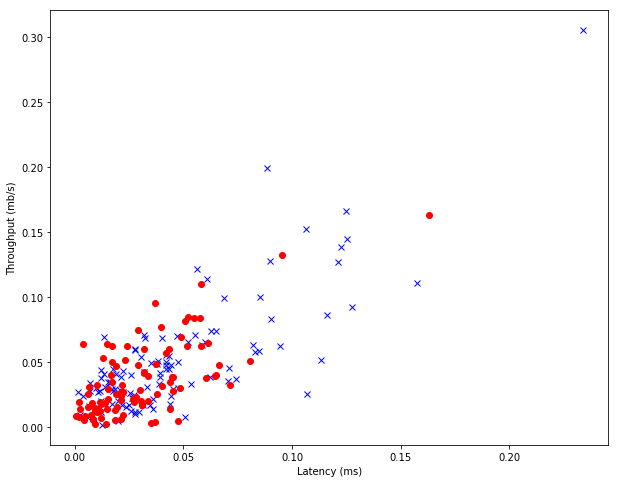

In [9]:
# membaca data
X,Y,y = read_dataset() #X - features , Y - labels
normalized_featues = feature_normalize(X)
plot_points(X,y)

#### Memulai Training

In [10]:
# transformasi data kedalam training dan testing
X,Y = shuffle(X,Y,random_state=1)
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.20, random_state=42)

In [11]:
# tampilkan bentuk train dan test data values
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(165, 59)
(165, 2)
(42, 59)
(42, 2)


Sebelum inisialisasi variabel, pastikan versi tensorflow sesuai, jika error, fungsi berikut dapat digunakan agar bisa menggunakan TensorFlow 1.X API

In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
# definisi dan inisialisasi variabel untuk bekerja dengan tensor
learning_rate = 0.1
training_epochs = 1000
cost_history = np.empty(shape=[1],dtype=float)
val_cost_history = np.empty(shape=[1],dtype=float)
accuracy_history = np.empty(shape=[1],dtype=float)
val_accuracy_history = np.empty(shape=[1],dtype=float)
n_dim = X.shape[1]
n_class = 2
x = tf.placeholder(tf.float32,[None,n_dim])
W = tf.Variable(tf.zeros([n_dim,n_class]))
b = tf.Variable(tf.zeros([n_class]))

In [14]:
# inisialisasi semua variabel
init = tf.global_variables_initializer()

In [15]:
# definisi fungsi cost
y_ = tf.placeholder(tf.float32,[None,n_class])
y = tf.nn.softmax(tf.matmul(x, W)+ b)
cost_function = tf.reduce_mean(-tf.reduce_sum((y_ * tf.log(y)),reduction_indices=[1]))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

In [16]:
# inisialisasi session
sess = tf.Session()
sess.run(init)

In [17]:
# kalkulasi cost dan akurasi pada setiap epoch
for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={x:train_x,y_:train_y})
    
    cost = sess.run(cost_function,feed_dict={x: train_x,y_: train_y})
    cost_history = np.append(cost_history,cost)
    val_cost = sess.run(cost_function,feed_dict={x: test_x, y_: test_y})
    val_cost_history = np.append(val_cost_history,val_cost)
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy = sess.run(accuracy, feed_dict={x: train_x, y_: train_y})
    accuracy_history = np.append(accuracy_history,accuracy)
    
    val_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    val_accuracy = sess.run(val_accuracy, feed_dict={x: test_x, y_: test_y})
    val_accuracy_history = np.append(accuracy_history,accuracy)

    print('epoch : ', epoch,  ' - ', 'cost: ', cost, 'val_cost: ', val_cost, 'accuracy: ', accuracy, 'val_accuracy: ', val_accuracy)

epoch :  0  -  cost:  0.68906105 val_cost:  0.6860537 accuracy:  0.5212121 val_accuracy:  0.5952381
epoch :  1  -  cost:  0.6861654 val_cost:  0.68189675 accuracy:  0.5212121 val_accuracy:  0.5952381
epoch :  2  -  cost:  0.68367696 val_cost:  0.67909706 accuracy:  0.5272727 val_accuracy:  0.5952381
epoch :  3  -  cost:  0.6813537 val_cost:  0.6769749 accuracy:  0.55151516 val_accuracy:  0.5952381
epoch :  4  -  cost:  0.67911965 val_cost:  0.6752134 accuracy:  0.55151516 val_accuracy:  0.61904764
epoch :  5  -  cost:  0.67695 val_cost:  0.67365503 accuracy:  0.55151516 val_accuracy:  0.61904764
epoch :  6  -  cost:  0.67483526 val_cost:  0.6722175 accuracy:  0.57575756 val_accuracy:  0.61904764
epoch :  7  -  cost:  0.6727712 val_cost:  0.67085636 accuracy:  0.58787876 val_accuracy:  0.61904764
epoch :  8  -  cost:  0.670755 val_cost:  0.66954726 accuracy:  0.5939394 val_accuracy:  0.5714286
epoch :  9  -  cost:  0.6687846 val_cost:  0.668276 accuracy:  0.630303 val_accuracy:  0.61904

epoch :  160  -  cost:  0.5386529 val_cost:  0.5546513 accuracy:  0.74545455 val_accuracy:  0.6904762
epoch :  161  -  cost:  0.5382102 val_cost:  0.5541638 accuracy:  0.74545455 val_accuracy:  0.6904762
epoch :  162  -  cost:  0.53777015 val_cost:  0.5536789 accuracy:  0.74545455 val_accuracy:  0.6904762
epoch :  163  -  cost:  0.5373326 val_cost:  0.5531964 accuracy:  0.74545455 val_accuracy:  0.6904762
epoch :  164  -  cost:  0.53689766 val_cost:  0.55271643 accuracy:  0.75151515 val_accuracy:  0.6904762
epoch :  165  -  cost:  0.5364653 val_cost:  0.55223894 accuracy:  0.75151515 val_accuracy:  0.6904762
epoch :  166  -  cost:  0.53603536 val_cost:  0.5517639 accuracy:  0.75151515 val_accuracy:  0.6904762
epoch :  167  -  cost:  0.535608 val_cost:  0.55129135 accuracy:  0.75151515 val_accuracy:  0.6904762
epoch :  168  -  cost:  0.5351831 val_cost:  0.5508211 accuracy:  0.75757575 val_accuracy:  0.6904762
epoch :  169  -  cost:  0.53476065 val_cost:  0.55035335 accuracy:  0.7575757

epoch :  240  -  cost:  0.5099024 val_cost:  0.52241516 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  241  -  cost:  0.5096115 val_cost:  0.5220849 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  242  -  cost:  0.509322 val_cost:  0.5217562 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  243  -  cost:  0.50903386 val_cost:  0.5214288 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  244  -  cost:  0.508747 val_cost:  0.521103 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  245  -  cost:  0.50846153 val_cost:  0.5207787 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  246  -  cost:  0.5081773 val_cost:  0.5204558 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  247  -  cost:  0.50789434 val_cost:  0.52013427 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  248  -  cost:  0.5076127 val_cost:  0.5198142 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  249  -  cost:  0.5073323 val_cost:  0.5194956 accuracy:  0.77575755 val

epoch :  320  -  cost:  0.49019757 val_cost:  0.5000081 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  321  -  cost:  0.48998937 val_cost:  0.49977165 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  322  -  cost:  0.48978183 val_cost:  0.49953616 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  323  -  cost:  0.48957506 val_cost:  0.49930158 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  324  -  cost:  0.4893691 val_cost:  0.4990679 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  325  -  cost:  0.4891639 val_cost:  0.49883515 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  326  -  cost:  0.48895952 val_cost:  0.49860314 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  327  -  cost:  0.48875585 val_cost:  0.49837223 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  328  -  cost:  0.4885529 val_cost:  0.4981421 accuracy:  0.77575755 val_accuracy:  0.7380952
epoch :  329  -  cost:  0.48835066 val_cost:  0.49791282 accuracy:  0.

epoch :  400  -  cost:  0.47564855 val_cost:  0.48360562 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  401  -  cost:  0.4754899 val_cost:  0.48342854 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  402  -  cost:  0.47533166 val_cost:  0.48325202 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  403  -  cost:  0.475174 val_cost:  0.4830761 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  404  -  cost:  0.47501677 val_cost:  0.4829008 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  405  -  cost:  0.47486007 val_cost:  0.48272604 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  406  -  cost:  0.47470388 val_cost:  0.4825519 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  407  -  cost:  0.47454807 val_cost:  0.48237833 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  408  -  cost:  0.4743928 val_cost:  0.48220533 accuracy:  0.7818182 val_accuracy:  0.7619048
epoch :  409  -  cost:  0.47423795 val_cost:  0.48203295 accuracy:  0.7818182 va

epoch :  481  -  cost:  0.46418485 val_cost:  0.47097498 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  482  -  cost:  0.46405876 val_cost:  0.47083822 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  483  -  cost:  0.4639329 val_cost:  0.47070193 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  484  -  cost:  0.46380734 val_cost:  0.47056597 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  485  -  cost:  0.46368217 val_cost:  0.47043046 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  486  -  cost:  0.4635573 val_cost:  0.47029537 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  487  -  cost:  0.46343273 val_cost:  0.47016066 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  488  -  cost:  0.46330854 val_cost:  0.47002628 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  489  -  cost:  0.46318462 val_cost:  0.46989244 accuracy:  0.7939394 val_accuracy:  0.7619048
epoch :  490  -  cost:  0.46306098 val_cost:  0.46975893 accuracy:  0.79393

epoch :  563  -  cost:  0.45480448 val_cost:  0.46099344 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  564  -  cost:  0.45470077 val_cost:  0.46088555 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  565  -  cost:  0.45459732 val_cost:  0.4607779 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  566  -  cost:  0.4544941 val_cost:  0.46067053 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  567  -  cost:  0.45439112 val_cost:  0.4605635 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  568  -  cost:  0.45428833 val_cost:  0.4604568 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  569  -  cost:  0.4541858 val_cost:  0.4603504 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  570  -  cost:  0.45408347 val_cost:  0.46024424 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  571  -  cost:  0.45398143 val_cost:  0.46013838 accuracy:  0.8060606 val_accuracy:  0.7619048
epoch :  572  -  cost:  0.45387957 val_cost:  0.4600328 accuracy:  0.8060606 va

epoch :  643  -  cost:  0.44716558 val_cost:  0.45321813 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  644  -  cost:  0.44707772 val_cost:  0.45313096 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  645  -  cost:  0.44698995 val_cost:  0.453044 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  646  -  cost:  0.44690242 val_cost:  0.45295724 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  647  -  cost:  0.44681498 val_cost:  0.45287073 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  648  -  cost:  0.44672778 val_cost:  0.45278445 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  649  -  cost:  0.44664076 val_cost:  0.45269844 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  650  -  cost:  0.44655383 val_cost:  0.45261252 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  651  -  cost:  0.44646707 val_cost:  0.4525269 accuracy:  0.8121212 val_accuracy:  0.78571427
epoch :  652  -  cost:  0.44638053 val_cost:  0.45244148 accuracy: 

epoch :  723  -  cost:  0.44062254 val_cost:  0.44689614 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  724  -  cost:  0.44054648 val_cost:  0.4468247 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  725  -  cost:  0.4404706 val_cost:  0.4467536 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  726  -  cost:  0.4403948 val_cost:  0.44668257 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  727  -  cost:  0.4403191 val_cost:  0.44661173 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  728  -  cost:  0.44024357 val_cost:  0.4465411 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  729  -  cost:  0.4401681 val_cost:  0.4464706 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  730  -  cost:  0.44009283 val_cost:  0.4464003 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  731  -  cost:  0.44001764 val_cost:  0.44633016 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  732  -  cost:  0.4399426 val_cost:  0.44626018 accuracy:  0.8242

epoch :  803  -  cost:  0.43491414 val_cost:  0.44169736 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  804  -  cost:  0.43484724 val_cost:  0.4416384 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  805  -  cost:  0.43478042 val_cost:  0.44157958 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  806  -  cost:  0.43471378 val_cost:  0.44152096 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  807  -  cost:  0.4346471 val_cost:  0.44146243 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  808  -  cost:  0.43458068 val_cost:  0.44140399 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  809  -  cost:  0.43451416 val_cost:  0.44134572 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  810  -  cost:  0.4344479 val_cost:  0.44128755 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  811  -  cost:  0.43438175 val_cost:  0.44122955 accuracy:  0.8242424 val_accuracy:  0.78571427
epoch :  812  -  cost:  0.43431562 val_cost:  0.44117174 accuracy: 

epoch :  883  -  cost:  0.42985964 val_cost:  0.43738624 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  884  -  cost:  0.42980003 val_cost:  0.4373371 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  885  -  cost:  0.4297405 val_cost:  0.4372882 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  886  -  cost:  0.42968106 val_cost:  0.4372393 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  887  -  cost:  0.4296216 val_cost:  0.43719065 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  888  -  cost:  0.42956233 val_cost:  0.437142 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  889  -  cost:  0.4295031 val_cost:  0.4370935 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  890  -  cost:  0.42944393 val_cost:  0.43704504 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  891  -  cost:  0.42938486 val_cost:  0.43699682 accuracy:  0.8242424 val_accuracy:  0.8095238
epoch :  892  -  cost:  0.4293259 val_cost:  0.43694863 accuracy:  0.8242424 val_a

epoch :  964  -  cost:  0.42527613 val_cost:  0.43374774 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  965  -  cost:  0.4252225 val_cost:  0.4337068 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  966  -  cost:  0.42516887 val_cost:  0.4336658 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  967  -  cost:  0.42511538 val_cost:  0.43362507 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  968  -  cost:  0.4250619 val_cost:  0.4335844 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  969  -  cost:  0.42500848 val_cost:  0.43354383 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  970  -  cost:  0.42495516 val_cost:  0.4335033 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  971  -  cost:  0.42490187 val_cost:  0.43346286 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  972  -  cost:  0.4248487 val_cost:  0.43342254 accuracy:  0.8242424 val_accuracy:  0.8333333
epoch :  973  -  cost:  0.42479554 val_cost:  0.43338236 accuracy:  0.8242424 va

In [18]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Akurasi training: ",(sess.run(accuracy, feed_dict={x: train_x, y_: train_y})))
print("Akurasi validasi: ",(sess.run(accuracy, feed_dict={x: test_x, y_: test_y})))

Akurasi training:  0.8242424
Akurasi validasi:  0.8333333


#### Visualisasi Hasil Training dan Validasi

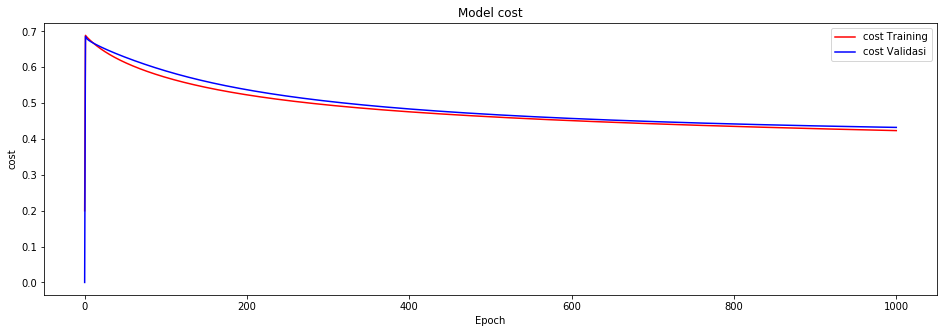

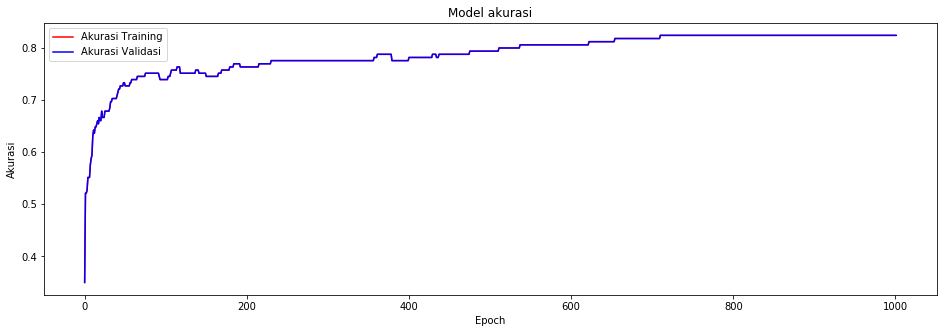

In [19]:
# Plot grafik cost training dan cost validasi
fig,(ax0) = plt.subplots(nrows=1, figsize=(16,5))
ax0.plot(cost_history,'red', label='cost Training')
ax0.plot(val_cost_history, 'blue', label='cost Validasi')
ax0.plot(label='cost', loc='upper left')
ax0.set_title('Model cost')
ax0.set_xlabel("Epoch")
ax0.set_ylabel("cost")
ax0.legend()

# Plot grafik akurasi training dan akurasi validasi
fig,(ax1) = plt.subplots(nrows=1, figsize=(16,5))
ax1.plot(accuracy_history,'red', label='Akurasi Training')
ax1.plot(val_accuracy_history, 'blue', label='Akurasi Validasi')
ax1.plot(label='Akurasi', loc='upper left')
ax1.set_title('Model akurasi')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Akurasi")
ax1.legend()

#### Kesimpulan
Pada hasil Neural Network diatas, hasil akurasi training dan akurasi validasi dengan menggunakan dataset Mines vs Rocks yang memiliki 207 baris dan 61 kolom, didapat :
- Akurasi Training = 82%
- Akurasi Validasi = 83%